# Music Classification using Machine Learning models

## Part 02 - Music Classification using ResNet50

In the second part of the project, based on the research of He, Kaiming, et al. "Deep residual learning for image recognition." [2] and Li, Jingxian, et al. "An evaluation of deep neural network models for music classification using spectrograms." [3], the ResNet50 model was chosen to be developed also because of the results obtained on the same dataset we used in this project (GTZAN).

### Preprocessing

The analysis will be done on the spectrograms images, which was generate a TXT file was generated with all their names so we can split the files into training and test sets. Following the procedures performed by Li, Jingxian, et al., the 9:1 ratio was used.

In [16]:
import os

def listFiles(filename, rootfolder, rf = True):
    with open(filename, "w") as a:
        folders = os.listdir(rootfolder)
        folders.sort()

        for f in folders:
            files = os.listdir(rootfolder + '/' + f)
            files.sort()

            for i in files:
                if rf:
                    name = rootfolder + '/' + f + '/' + i
                else:
                    name = f + '/' + i
                    
                a.write(str(name) + os.linesep)

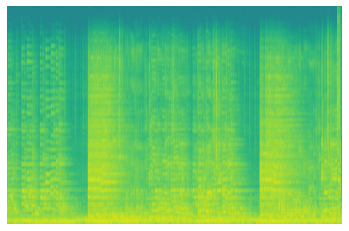

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile

listFiles("audio-files.txt", "genres_original")

with open("audio-files.txt", 'r') as audio_file:
    for audio in audio_file:
        audio = audio[:-1]
        _, genre, name = audio.split('/')
        nameGenre, nameNum, _ = name.split('.')
        name = nameGenre + '.' + nameNum + ".png"
        
        if not os.path.isdir("audio-spec/" + genre):
            os.makedirs("audio-spec/" + genre)
        
        Fs, aud = wavfile.read(audio)
        powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(aud, Fs = Fs)
        plt.axis('off')
        plt.savefig("audio-spec/" + genre + '/' + name)

In [17]:
listFiles("images_files.txt", "audio-spec", rf = False)

In [26]:
import random
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

#Split Train and Test sets
with open("images_files.txt", 'r') as fp:
	data = [(random.random(), line) for line in fp]
	dataset_size = len(data)
    
	train_perc = 0.9
	valid_perc = 0.1
    
	num_train_samples = int(dataset_size * train_perc)
	num_valid_samples = int(dataset_size * valid_perc)

	data.sort()

#Create train file
with open("train_comparisons.txt", 'w') as train:
	for _, line in data[:num_train_samples]:
		train.write(line)

#Create test file
with open("valid_comparisons.txt", 'w') as valid:
	for _, line in data[:num_valid_samples]:
		valid.write(line)

#Folder with images of a dataset
image_folder = "./audio-spec"

#File with image comparisons for training
train_imagenames_file = "./train_comparisons.txt" 

#File with image comparisons for validation
valid_imagenames_file = "./valid_comparisons.txt" 

Using cpu device


When loading the images, a 224 x224 size crop and Tensor transformation was performed as preprocessing and the labels with the true values were extracted from the folder where the files are located. Also, since we have a large sample of files, we created batches of size 64.

In [27]:
import numpy as np

#Preprocessing images
class ResNet50Dataset():
	def __init__(self, image_folder, imagenames_file, transform=None):
		self.image_folder = image_folder
		self.imagenames_file = imagenames_file
		self.nitems = 0
		self.transform = transform

		f = open(self.imagenames_file, "r")

		self.elements = []
		for line in f:
		    elements = line.strip().split(" ")
		    self.elements.append(elements)

		self.nitems = len(self.elements)

	def __getitem__(self, x):
		image1 = self.elements[x]

		#Get the label from the file name (blues/blues00000.png -> blues)
		label = image1[0].split("/")[0]
        
        #Save name as value of the dictionary
		labels = {"blues": 0, "classical": 1, "country": 2, "disco": 3, "hiphop": 4, "jazz": 5, "metal": 6, "pop": 7, "reggae": 8, "rock": 9}
		label = labels[label]

        #Read image
		image1 = read_image("{}/{}".format(self.image_folder, image1[0]), mode=image.ImageReadMode.RGB)

        #Apply transformation (prep)
		if self.transform:
			image1 = self.transform(image1)

		return image1, np.array([label])

	def __len__(self):
		return self.nitems

In [28]:
from torchvision.transforms.transforms import ToPILImage
from torchvision import datasets, transforms

#Creating object of class ResNet50
prep = transforms.Compose([transforms.ToPILImage(), transforms.Resize((224, 224)), transforms.ToTensor()])
dataset = ResNet50Dataset(image_folder = image_folder, imagenames_file = train_imagenames_file, transform = prep)

In [29]:
from torch.utils.data import DataLoader

#Split Dataset in batches
def GetBatches(image_folder, image_names, batchsize, transformation):
    datatensor = ResNet50Dataset(image_folder, image_names, transformation) 
    dataloader = DataLoader(datatensor, batch_size = batchsize, shuffle=True)
    return(dataloader)

In [30]:
#Create data's batches
batchsize = 64

trainload = GetBatches(image_folder, train_imagenames_file, batchsize, prep)  
validload = GetBatches(image_folder, valid_imagenames_file, batchsize, prep)

print("Number training batches: ", len(trainload))
print("Number validation batches: ", len(validload))

Number training batches:  15
Number validation batches:  2


### Deep Neural Network

Based on the results obtained by this same paper with different state-of-the-art neural networks (VGGNet16, ResNet50, DenseNet121, NASNetMobile, MobileNetV2), the ResNet50 model was the one that presented the best accuracy in the results. Widely used, it has a residual network structure that performs Skip Connections, which allows the neural network to have good results without having necessarily to create additional layers that have no strong positive impact on the result. For this, we used the standard implementation present in the PyTorch library. 

In the article on which this code is based, changes are presented in the final part of the ResNet50 architecture after the 5th convolution layer, changing the Loss function to generate more reliable results - ResNet50_trust. For this project, this change was not implemented given the satisfactory results found with the model itself.

In [31]:
from torchvision.models import resnet50
import torch.nn as nn

#Create ResNet50 model
model = resnet50(weights = None).to(device)
model.fc = nn.Linear(2048, 10)

The output result of the model consists of a 1000-d vector. Therefore, to perform the calculation of Loss and Accuracy of the model, we applied the one hot encoder function on the music genres to 1000 classes.

In [32]:
from torchmetrics import Accuracy

#Function to train batches
def train_batch(model, data, optimizer, criterion):
	imgsA, labels = [t.to(device) for t in data]
	imgsA = imgsA.to(torch.float32)
    
    #Apply One Hot Encode for labels 
	labels = torch.reshape(labels, (-1,))
	labels = nn.functional.one_hot(labels, num_classes = 10).to(torch.float32)
    
    #Run the model
	optimizer.zero_grad()
	codesA = model(imgsA)
    
    #Calculate Loss and Accuracy
	loss = criterion(codesA, labels)
	accuracy = Accuracy(task='multilabel', num_labels = 10)
	acc = accuracy(codesA, labels)

	loss.backward()
	optimizer.step()

	return loss.item(), acc

#Function to validate batches
def valid_batch(model, data, criterion):
	imgsA, labels = [t.to(device) for t in data]
	imgsA = imgsA.to(torch.float32)

    #Apply One Hot Encode for labels 
	labels = torch.reshape(labels, (-1,))
	labels = nn.functional.one_hot(labels, num_classes = 10).to(torch.float32)

    #Run the model
	model.eval()
	codesA = model(imgsA)

    #Calculate Loss and Accuracy
	loss = criterion(codesA, labels)
	accuracy = Accuracy(task='multilabel', num_labels = 10)
	acc = accuracy(codesA, labels)

	model.train()

	return loss.item(), acc

As in the article, Adam was used as optimizer with a learning rate of 0.001 and, according to ResNet50 pattern, the CrossEntropyLoss function was used as a criterion in the 6 epochs run. As shown in the graph, the results obtained present very good accuracy and a considerably lower Loss that still needs improvement.

EPOCH: 10.000	val_loss: 10.313	val_acc: 0.589	(3069.31s - 0.00s remaining)))

100%|██████████| 111/111 [00:00<00:00, 4318.05it/s]


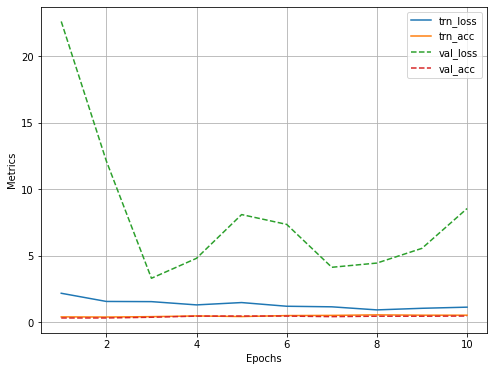

In [34]:
from torchvision.io import read_image, image
from torch_snippets import *

optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.01)
criterion = nn.CrossEntropyLoss()
nepochs = 10

log = Report(nepochs)

for epoch in range(nepochs):

	N = len(trainload)
	for i, data in enumerate(trainload):
		batch_loss, batch_acc = train_batch(model, data, optimizer, criterion)
		log.record(epoch + (1 + i) / N, trn_loss = batch_loss, trn_acc = batch_acc, end = '\r')

	N = len(validload)
	with torch.no_grad():
		for i, data in enumerate(validload):
			batch_loss, batch_acc  = valid_batch(model, data, criterion)
			log.record(epoch + (1 + i) / N, val_loss = batch_loss, val_acc = batch_acc, end = '\r')  
            
log.plot_epochs() 

In [11]:
#Save model
torch.save(model.state_dict(), "ResNet50.pth")

### Evaluation

The model was also evaluated on the test set and presented similar accuracy to the training set, but with a worse performance on Loss, which means that it is necessary to increase the number of epochs to understand the trend of the graph and, thus, verify the possibility of an overfitting. 

In [12]:
#Evaluate model
model_path = './ResNet50.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

test_image_folder = "./images_original"  
test_imagenames_file = "./valid_comparisons.txt"
testload = GetBatches(test_image_folder, test_imagenames_file, batchsize, prep)
inspect(next(iter(testload)))

list of 2 items
	Tensor	Shape: torch.Size([64, 3, 224, 224])	Min: 0.000	Max: 1.000	Mean: 0.478	dtype: torch.float32 @ cpu
	Tensor	Shape: torch.Size([64, 1])	Min: 0.000	Max: 9.000	Mean: 4.641	dtype: torch.int64 @ cpu


In [13]:
#put model in evaluation mode
model.eval()

Acc = []
Loss = []
Labels = []

#process all batches
for ix, data in enumerate(testload):
    imgsA, labels = [t.to(device) for t in data]

    imgsA = imgsA.to(torch.float32)

    labels = torch.reshape(labels, (-1,))
    labels = nn.functional.one_hot(labels, num_classes = 10).to(torch.float32)
    
    with torch.no_grad():
        codesA = model(imgsA)
        loss = criterion(codesA, labels)
        
        accuracy = Accuracy(task='multilabel', num_labels = 10)
        acc = accuracy(codesA, labels)

        Labels.append(labels)
        Acc.append(acc.detach().cpu().numpy())
        Loss.append(loss.detach().cpu().numpy())

print('Accuracy on the test set: {:.6f}'.format(np.mean(Acc)))
print('Loss on the test set: {:.6f}'.format(np.mean(Loss)))

Accuracy on the test set: 0.991000
Loss on the test set: 3.184516


One way to analyze the results obtained with the model created is by plotting graphs that show the spatial division performed for each class or a histogram that shows the distance between these classes. In this case we used PCA to reduce the dimensionality to 2-d but the result we obtained does not allow us to spatially distinguish each music genre, and consequently also prevents us from inferring about how the different music genres relate to each other.

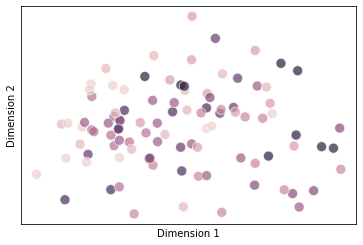

In [25]:
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from torchvision.io import read_image, image
from torch_snippets import *

model.eval()

image_folder = './images_original'
imagenames_file = './valid_comparisons.txt'

dataset = ResNet50Dataset(image_folder, imagenames_file, prep) 
dataloader = DataLoader(dataset, batch_size = 128, shuffle = True)

dataiter = iter(dataloader)
image1, label = [t.to(device) for t in next(dataiter)]

label = label.numpy()
output1 = model(image1)
output1 = output1.detach().numpy()

pca = PCA(n_components = 2)
output1 = pca.fit_transform(output1)

LabeledData = np.append(output1, label, axis = 1)
LabeledData = pd.DataFrame(data = LabeledData, columns = ["Dimension 1", "Dimension 2", 'Label'])

sns.scatterplot(data = LabeledData, x = "Dimension 1", y = "Dimension 2", hue = 'Label', alpha = 0.7, s = 100, legend = False)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
model.eval()
do_comparison = 'y'

image_folder = './images_original'
imagenames_file = './valid_comparisons.txt'

dataset = ResNet50Dataset(image_folder, imagenames_file, prep) 
dataloader = DataLoader(dataset, batch_size = 1, shuffle = True)

labels = {0: "blues", 1: "classical", 2: "country", 3: "disco", 4: "hiphop", 5: "jazz", 6: "metal", 7: "pop", 8: "reggae", 9: "rock"}

while (do_comparison == 'y'):
    dataiter = iter(dataloader)
    image1, truelabel = [t.to(device) for t in next(dataiter)]
    image1 = image1 * 0.5 + 0.5

    output1 = model(image1)
    _, preds = torch.max(output1, 1)
    
    if truelabel == preds:
        output = 'Correct.'

    else:
        output = 'Wrong, should be ' + labels[truelabel.item()]

    show(torchvision.utils.make_grid(image1), title='Prediction: {}\n{}'.format(labels[preds.item()], output))
    plt.show()
    do_comparison = input("Type y to continue: ")

## References

[2] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).

[3] Li, J., Han, L., Li, X., Zhu, J., Yuan, B., & Gou, Z. (2022). An evaluation of deep neural network models for music classification using spectrograms. Multimedia Tools and Applications, 1-27.